In [1]:
# Import Statements

#General Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

C:\Users\txcwa\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Reading in kenpom data 
kenpom_raw_df = pd.read_csv('data/kenpom_raw.csv')

#Spliting Team to get tournament seed and dropping ranks for all other stats
kenpom_df = kenpom_raw_df.drop(['Rk', 'Unnamed: 6','Unnamed: 8','Unnamed: 10','Unnamed: 12','Unnamed: 14','Unnamed: 16'
                                ,'Unnamed: 18','Unnamed: 20'], axis = 1)

kenpom_df[['Team', 'Seed']] = kenpom_df['Team'].str.extract(r'^(.*?)(\d*)\*?$')
kenpom_df['Team'] = kenpom_df['Team'].str.rstrip()
kenpom_df

,Team,Conf,W-L,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM.1,OppO,OppD,AdjEM.2,Year,Seed
0,Kentucky,SEC,32-4,29.18,116.5,87.4,67.7,0.051,11.20,108.6,97.4,6.77,2003,1
1,Kansas,B12,30-8,28.62,115.0,86.4,72.2,-0.017,11.84,108.6,96.8,6.07,2003,2
2,Pittsburgh,BE,28-5,28.61,114.8,86.2,64.7,-0.023,7.08,105.5,98.4,-8.24,2003,2
3,Arizona,P10,28-4,26.80,115.6,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,2003,1
4,Illinois,B10,25-7,24.47,113.2,88.7,67.8,-0.029,7.29,105.8,98.5,-4.18,2003,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7618,Stonehill,NEC,4-27,-22.89,91.9,114.8,67.6,-0.078,-4.92,102.2,107.2,4.28,2024,
7619,Pacific,WCC,6-26,-22.91,95.2,118.2,68.2,-0.014,-0.04,106.3,106.3,-4.90,2024,
7620,IUPUI,Horz,6-26,-25.63,92.1,117.7,67.3,-0.019,-2.97,106.2,109.2,-4.18,2024,
7621,Coppin St.,MEAC,2-27,-25.86,85.6,111.5,66.0,-0.057,-5.13,102.8,107.9,0.72,2024,


In [3]:
# Creating Kenpom seed which is sorting on NetRtg (efficency on both sides of the ball) and giving every four teams the next numerical seed
# The first four teams get 1 the next four get 2, etc etc until the 64th team gets 16

def assign_kenpom_seed(df):
    # Sort by 'NetRtg' within each year and assign ranking
    df = df.sort_values(by='AdjEM', ascending=False).reset_index(drop=True)

    # Assign seeds 1 to 16 for top 64 teams, remaining get seed 99
    df['kenpom_seed'] = np.where(df.index < 64, (df.index // 4) + 1, 99)

    return df

# Group by 'year' and apply the seed assignment function
kenpom_df = kenpom_df.groupby('Year', group_keys=False).apply(assign_kenpom_seed)

# Display the updated DataFrame with 'kenpom_seed' column
print(kenpom_df)

#This works really well for the top end which is mostly what we care about but is a disaster at the lower end since
# a bunch of smaller schools make the tournament and take the 13 - 16 seeds. There are ways to fix this (Described below)
# but for the moment this is more than sufficient since this is not going to be used on the model. And is more of a comparison tool
# for the upper end on how the model does.

# This can fixed by including this for the top 50 teams then looking at teams in the tier 3 of conferences and randomizing the
# First few teams in each mid major conference a seed between 13-16. If these conferences have a team in the top 50 then we can
# assume they are the conference representatitve and ignore this process. 

                       Team  Conf   W-L  AdjEM   AdjO   AdjD  AdjT   Luck  \
0                  Kentucky   SEC  32-4  29.18  116.5   87.4  67.7  0.051   
1                    Kansas   B12  30-8  28.62  115.0   86.4  72.2 -0.017   
2                Pittsburgh    BE  28-5  28.61  114.8   86.2  64.7 -0.023   
3                   Arizona   P10  28-4  26.80  115.6   88.8  72.7 -0.007   
4                  Illinois   B10  25-7  24.47  113.2   88.7  67.8 -0.029   
..                      ...   ...   ...    ...    ...    ...   ...    ...   
357               Stonehill   NEC  4-27 -22.89   91.9  114.8  67.6 -0.078   
358                 Pacific   WCC  6-26 -22.91   95.2  118.2  68.2 -0.014   
359                   IUPUI  Horz  6-26 -25.63   92.1  117.7  67.3 -0.019   
360              Coppin St.  MEAC  2-27 -25.86   85.6  111.5  66.0 -0.057   
361  Mississippi Valley St.  SWAC  1-30 -31.26   85.3  116.6  64.6 -0.060   

     AdjEM.1   OppO   OppD  AdjEM.2  Year Seed  kenpom_seed  
0      11.20 

In [4]:
kenpom_df_2024 = kenpom_df[kenpom_df['Year'] == 2024]
kenpom_df_2024.head(20)

,Team,Conf,W-L,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM.1,OppO,OppD,AdjEM.2,Year,Seed,kenpom_seed
0,Connecticut,BE,31-3,32.21,126.6,94.4,64.5,0.047,10.46,111.6,101.2,-3.36,2024,1,1
1,Houston,B12,30-4,31.72,118.9,87.1,63.3,0.053,11.75,111.9,100.1,-0.79,2024,1,1
2,Purdue,B10,29-4,29.12,125.0,95.9,67.4,0.045,13.74,114.0,100.3,10.35,2024,1,1
3,Auburn,SEC,27-7,28.90,120.6,91.7,69.8,-0.067,9.60,111.9,102.3,1.45,2024,4,1
4,Iowa St.,B12,27-7,26.72,113.9,87.1,67.3,0.012,10.38,111.0,100.6,-7.20,2024,2,2
5,Arizona,P12,25-8,26.62,121.1,94.5,71.8,-0.043,10.79,111.9,101.1,10.43,2024,2,2
6,Tennessee,SEC,24-8,25.97,117.0,91.0,69.2,-0.030,12.63,114.3,101.7,8.50,2024,2,2
7,Duke,ACC,24-8,24.88,121.8,97.0,66.7,-0.077,8.55,110.6,102.0,0.13,2024,4,2
8,North Carolina,ACC,27-7,24.65,117.8,93.2,70.4,-0.024,11.24,112.4,101.2,7.07,2024,1,3
9,Illinois,B10,26-8,23.99,125.6,101.6,69.9,-0.032,11.08,111.6,100.5,-2.25,2024,3,3


In [5]:
# Not filled observations in Seed column are not recognized as nan so need to converted before the column can be filled and
# finally converted to dtype int
kenpom_df['Seed'] = kenpom_df['Seed'].replace('', np.nan)
kenpom_df['Seed'] = kenpom_df['Seed'].fillna(99)
kenpom_df['Seed'] = kenpom_df['Seed'].astype(int)

# Creating variable for see difference
kenpom_df['Seed_Difference'] = kenpom_df['Seed'].astype(int) - kenpom_df['kenpom_seed'].astype(int)
kenpom_df['Seed_Difference'] = kenpom_df['Seed_Difference'].astype(int)
kenpom_df

,Team,Conf,W-L,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM.1,OppO,OppD,AdjEM.2,Year,Seed,kenpom_seed,Seed_Difference
0,Kentucky,SEC,32-4,29.18,116.5,87.4,67.7,0.051,11.20,108.6,97.4,6.77,2003,1,1,0
1,Kansas,B12,30-8,28.62,115.0,86.4,72.2,-0.017,11.84,108.6,96.8,6.07,2003,2,1,1
2,Pittsburgh,BE,28-5,28.61,114.8,86.2,64.7,-0.023,7.08,105.5,98.4,-8.24,2003,2,1,1
3,Arizona,P10,28-4,26.80,115.6,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,2003,1,1,0
4,Illinois,B10,25-7,24.47,113.2,88.7,67.8,-0.029,7.29,105.8,98.5,-4.18,2003,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,Stonehill,NEC,4-27,-22.89,91.9,114.8,67.6,-0.078,-4.92,102.2,107.2,4.28,2024,99,99,0
358,Pacific,WCC,6-26,-22.91,95.2,118.2,68.2,-0.014,-0.04,106.3,106.3,-4.90,2024,99,99,0
359,IUPUI,Horz,6-26,-25.63,92.1,117.7,67.3,-0.019,-2.97,106.2,109.2,-4.18,2024,99,99,0
360,Coppin St.,MEAC,2-27,-25.86,85.6,111.5,66.0,-0.057,-5.13,102.8,107.9,0.72,2024,99,99,0


In [6]:
def limit_seeds(df):
    # Sort the dataframe by Year and Seed
    df = df.sort_values(by=['Year', 'Seed'])
    
    # Group by Year
    df['Seed_Count'] = df.groupby(['Year', 'Seed']).cumcount() + 1  # Count occurrences of each seed per year
    
    # Set any Seed where the count is greater than 4 to 99
    df.loc[df['Seed_Count'] > 4, 'Seed'] = 99
    
    # Drop the Seed_Count helper column
    df.drop('Seed_Count', axis=1, inplace=True)
    
    return df

# Apply the function to your DataFrame
kenpom_df = limit_seeds(kenpom_df)

# Creating variable for see difference
kenpom_df['Seed_Difference'] = kenpom_df['Seed'].astype(int) - kenpom_df['kenpom_seed'].astype(int)
kenpom_df['Seed_Difference'] = kenpom_df['Seed_Difference'].astype(int)
kenpom_df

# Display the updated DataFrame
kenpom_snub_df = kenpom_df.sort_values(by = 'Seed_Difference', key = lambda x: x.abs(), ascending = False)
kenpom_snub_df.head(20)


,Team,Conf,W-L,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM.1,OppO,OppD,AdjEM.2,Year,Seed,kenpom_seed,Seed_Difference
6,Louisville,ACC,23-8,24.68,113.4,88.8,66.1,-0.025,7.49,110.4,102.9,-7.40,2016,99,2,97
15,SMU,Amer,25-5,21.98,119.3,97.3,65.8,0.014,3.37,105.5,102.2,-1.06,2016,99,4,95
15,Georgia,SEC,19-8,20.93,120.9,99.9,67.1,0.012,12.71,108.7,96.0,10.85,2003,99,4,95
19,Air Force,MWC,26-9,20.20,116.5,96.3,57.5,-0.021,3.24,106.5,103.2,-1.91,2007,99,5,94
23,Purdue,B10,16-15,18.57,109.3,90.8,64.6,-0.104,12.19,108.4,96.3,2.78,2020,99,6,93
27,Michigan,B10,22-11,15.98,113.1,97.2,67.0,0.012,7.94,106.7,98.8,-0.97,2006,99,7,92
26,Minnesota,B10,15-16,17.83,112.1,94.2,66.8,-0.130,12.38,108.6,96.2,2.88,2020,99,7,92
25,Florida St.,ACC,19-14,17.48,109.0,91.5,64.3,-0.090,10.38,109.1,98.7,-6.81,2004,99,7,92
27,Baylor,B12,23-14,17.89,114.3,96.4,66.4,-0.090,6.92,106.0,99.1,1.45,2013,99,7,92
24,Texas,B12,21-16,19.11,113.5,94.4,64.7,-0.080,11.96,110.3,98.3,4.98,2019,99,7,92


In [7]:
kenpom_misseed_df = kenpom_snub_df[kenpom_snub_df['Seed_Difference'].abs() < 20]
kenpom_misseed_df.head(25)

,Team,Conf,W-L,AdjEM,AdjO,AdjD,AdjT,Luck,AdjEM.1,OppO,OppD,AdjEM.2,Year,Seed,kenpom_seed,Seed_Difference
55,Vanderbilt,SEC,26-8,12.65,112.3,99.6,68.2,0.110,5.20,107.4,102.2,-1.70,2008,4,14,-10
63,Oregon St.,P12,19-13,11.65,110.7,99.1,67.1,0.043,9.61,109.8,100.2,0.46,2016,7,16,-9
57,DePaul,CUSA,22-10,11.36,113.0,101.6,63.2,0.091,5.83,106.4,100.6,-0.62,2004,7,15,-8
7,Wichita St.,MVC,31-5,26.14,118.7,92.6,68.0,-0.021,1.50,105.0,103.5,-0.32,2017,10,2,8
56,Missouri,SEC,25-10,13.07,118.3,105.3,68.7,0.107,7.33,107.7,100.3,-5.09,2023,7,15,-8
20,Utah St.,BW,24-8,19.62,116.0,96.4,61.1,-0.094,-2.48,101.3,103.8,-4.48,2005,14,6,8
9,Tennessee,SEC,24-13,23.69,117.9,94.2,61.6,-0.099,8.12,108.9,100.8,1.46,2014,11,3,8
47,Virginia,ACC,21-11,15.43,114.1,98.7,67.9,0.006,8.27,109.2,100.9,-4.35,2007,4,12,-8
58,Dayton,A10,25-8,12.63,106.6,94.0,67.8,0.082,3.89,107.3,103.4,2.58,2016,7,15,-8
53,Charlotte,CUSA,21-8,12.15,111.6,99.5,70.6,0.042,3.68,104.9,101.2,-1.74,2005,7,14,-7


In [8]:
# From the above we can see that the Kenpom seeding is probably a more accurate reflection of a teams strength below are the
# outcomes of all the listed teams
# Vanderbilt 2008: Smoked in first round by 13 seed Siena
# Davidson 2008: Made Elite 8 and lost by 2 to eventual champion Kansas
# Oregon St. 2016: Lost to VCU in first game
# Dayton 2016: lost to Syracuse in first game
# Wichita St. 2016: Won play in and second round game bfore losiing in round of 32 to 3 seed Miami
# DePaul 2004 beat Dayton in first game and lost in second round to Uconn
# Washington 2004: Lost to UAB in first game
# Wichita St 2017 Lost to Kentucky (2 seed) in second game
# Missouri 2023: beat UT St. in first game but the lost to 15 seed Princeton in next game
# Utah St. 2005: Lost to Arizona (3 seed) in first game
# Charlotte 2005: Lost to NC State in first game
# Tennessee 2014: Made Sweet 16 but did not have to beat 3 seed Duke since the lost to Mercer in their first game
# UMass 2014: Played Tennessee (from above) in first round and lost
# Virginia 2007: Lost to Tennessee in second round 4 v 5 seed
# UCLA 2021: Lost to Gonzaga in Final Four
# Belmont 2012: Lost to Georgetown (3 seed) in first round
# Minnesota 2012: Not in Tourney?? 
# Richmond 2010: Lost in first game to Saint Mary's
# Wisconsin 2022: Lost to 11 seed Iowa St. in second game  
# South Carolina 2024: Lost to Oregon (11 Seed) in first game
# Belmont 2011: Lost to Wisconsin (4 seed) in first game
# Colorado 2016: Lost to Uconn in 8,9 mathcup
# Tennessee 2011: Smoked by Michigan in 8,9 matchup

In [9]:
#Prepping dataframe for Cluster algorithm



# Define conference tiers definition based on 2024 seeding results
conference_tiers = {
    'SEC': 1, 'B12': 1, 'B10': 1, 'ACC': 1, 'BE': 1, 'P12': 1, 'MWC': 1, 'P10':1,
    'A10': 2, 'AMER': 2, 'MVC': 2, 'WCC': 2
}

# Assign Tier 3 to the rest of the conferences
all_conferences = set(kenpom_df['Conf'].unique())
tier_three_conferences = all_conferences - set(conference_tiers.keys())
conference_tiers.update({conf: 3 for conf in tier_three_conferences})

# Create a function to map conferences to tiers
def map_tier(conf):
    return conference_tiers.get(conf, 3)  # Default to tier 3 if not found

# Apply conference tier mapping to Conf_A and Conf_B columns
kenpom_df['Conf_Tier'] = kenpom_df['Conf'].apply(map_tier)

# Create LabelEncoder object (for conferences)
label_encoder = LabelEncoder()

# Fit and transform Conf_A and Conf_B columns to integers
kenpom_df['Conf'] = label_encoder.fit_transform(kenpom_df['Conf'])

#Renaming a few columns
kenpom_df = kenpom_df.rename(columns = {'AdjEM':'NetRtg','AdjEM.1':'SOS_NetRtg','AdjEM.2':'NCSOS_NetRtg'})

# Split the W-L column into two columns: W and L
kenpom_df[['W', 'L']] = kenpom_df['W-L'].str.split('-', expand=True)

# Convert both columns to numeric
kenpom_df['W'] = pd.to_numeric(kenpom_df['W'])
kenpom_df['L'] = pd.to_numeric(kenpom_df['L'])

kenpom_df

,Team,Conf,W-L,NetRtg,AdjO,AdjD,AdjT,Luck,SOS_NetRtg,OppO,OppD,NCSOS_NetRtg,Year,Seed,kenpom_seed,Seed_Difference,Conf_Tier,W,L
0,Kentucky,29,32-4,29.18,116.5,87.4,67.7,0.051,11.20,108.6,97.4,6.77,2003,1,1,0,1,32,4
3,Arizona,24,28-4,26.80,115.6,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,2003,1,1,0,1,28,4
6,Texas,6,26-7,23.49,119.3,95.8,69.4,-0.009,10.36,107.1,96.7,2.16,2003,1,2,-1,1,26,7
8,Oklahoma,6,27-7,23.01,112.1,89.1,62.7,0.034,9.01,106.7,97.7,-2.32,2003,1,3,-2,1,27,7
1,Kansas,6,30-8,28.62,115.0,86.4,72.2,-0.017,11.84,108.6,96.8,6.07,2003,2,1,1,1,30,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,Stonehill,22,4-27,-22.89,91.9,114.8,67.6,-0.078,-4.92,102.2,107.2,4.28,2024,99,99,0,3,4,27
358,Pacific,34,6-26,-22.91,95.2,118.2,68.2,-0.014,-0.04,106.3,106.3,-4.90,2024,99,99,0,2,6,26
359,IUPUI,14,6-26,-25.63,92.1,117.7,67.3,-0.019,-2.97,106.2,109.2,-4.18,2024,99,99,0,3,6,26
360,Coppin St.,19,2-27,-25.86,85.6,111.5,66.0,-0.057,-5.13,102.8,107.9,0.72,2024,99,99,0,3,2,27


In [10]:
kenpom_tourney = kenpom_df[kenpom_df['Seed']<20]

In [16]:
kenpom_knn_model_df = kenpom_tourney.drop(['Team','W-L','kenpom_seed','Seed_Difference'], axis = 1)
kenpom_knn_model_2024 = kenpom_knn_model_df[kenpom_knn_model_df['Year'] == 2024]

In [17]:
kenpom_knn_model_df_2023 = kenpom_knn_model_df[kenpom_knn_model_df['Year'] != 2024]
kenpom_knn_model_df_2023

,Conf,NetRtg,AdjO,AdjD,AdjT,Luck,SOS_NetRtg,OppO,OppD,NCSOS_NetRtg,Year,Seed,Conf_Tier,W,L
0,29,29.18,116.5,87.4,67.7,0.051,11.20,108.6,97.4,6.77,2003,1,1,32,4
3,24,26.80,115.6,88.8,72.7,-0.007,8.69,107.2,98.5,8.19,2003,1,1,28,4
6,6,23.49,119.3,95.8,69.4,-0.009,10.36,107.1,96.7,2.16,2003,1,1,26,7
8,6,23.01,112.1,89.1,62.7,0.034,9.01,106.7,97.7,-2.32,2003,1,1,27,7
1,6,28.62,115.0,86.4,72.2,-0.017,11.84,108.6,96.8,6.07,2003,2,1,30,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,9,1.22,104.0,102.7,68.3,0.180,-4.62,102.7,107.3,-0.70,2023,15,3,27,8
159,14,0.65,102.8,102.2,62.0,0.046,-3.56,104.3,107.9,4.03,2023,16,3,22,13
175,31,-0.48,107.1,107.6,69.0,0.031,-8.63,100.9,109.6,1.13,2023,16,3,24,11
217,19,-3.38,103.5,106.9,69.0,0.096,-5.60,101.3,106.9,-0.01,2023,16,3,22,13


In [14]:
# Define your feature variables (X) and target variable (y)
X = kenpom_knn_model_df.drop('Seed', axis = 1)  # Example features
y = kenpom_knn_model_df['Seed'].astype(int)  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Set up the parameter grid for k
param_grid = {'n_neighbors': np.arange(1, 31)}

# Set up the KNN classifier
knn = KNeighborsClassifier()

# Perform grid search
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
knn_gscv.fit(X_train, y_train)

# Get the best K
best_k = knn_gscv.best_params_['n_neighbors']
print(f"Best value for k: {best_k}")

# Train the model with the best k
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)

Best value for k: 30


KNeighborsClassifier(n_neighbors=30)

Accuracy: 0.30
              precision    recall  f1-score   support

           1       0.83      0.71      0.77        21
           2       0.22      0.33      0.27        12
           3       0.24      0.29      0.26        14
           4       0.20      0.14      0.17        14
           5       0.16      0.33      0.21        15
           6       0.21      0.15      0.18        20
           7       0.07      0.08      0.08        12
           8       0.15      0.14      0.14        22
           9       0.10      0.19      0.13        16
          10       0.12      0.12      0.12        17
          11       0.33      0.04      0.07        24
          12       0.36      0.21      0.26        24
          13       0.42      0.45      0.43        22
          14       0.44      0.37      0.40        19
          15       0.50      0.67      0.57        12
          16       0.69      0.69      0.69        16

    accuracy                           0.30       280
   macro av

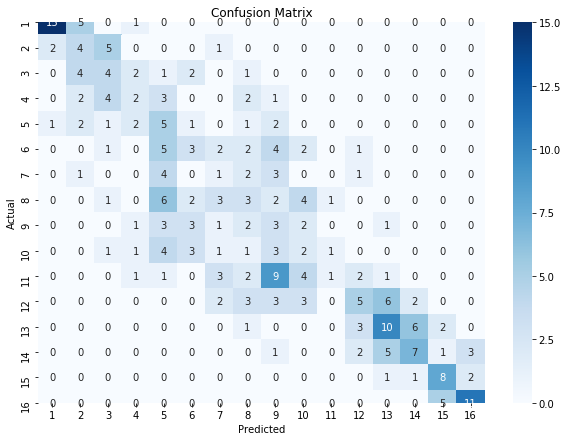

In [15]:
# Make predictions
y_pred = knn_best.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y), 
            yticklabels=np.unique(y))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Plot accuracy for different values of k
k_values = np.arange(1, 31)
train_scores = []
test_scores = []

for k in k_values:
    knn_k = KNeighborsClassifier(n_neighbors=k)
    knn_k.fit(X_train, y_train)
    train_scores.append(knn_k.score(X_train, y_train))
    test_scores.append(knn_k.score(X_test, y_test))

plt.figure(figsize=(12, 6))
plt.plot(k_values, train_scores, label='Train Accuracy')
plt.plot(k_values, test_scores, label='Test Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Model Accuracy for Different k Values')
plt.legend()
plt.grid()
plt.show()
